# Reinforcement Learning

# I. Overview

The main objective of this assignment is to learn and apply reinforcement learning algorithms on two different problems: 2D Marble Control and the Mountain Car game. Below is a detailed summary of the tasks which will be accomplished to solve the problems:

In the first problem, a 1-D Marble Class is provided which defines the possible actions which marble can take like moving left, right, or taking no action. The goal for the marble is set in on a one-dimensional plane where marble can be pushed in either direction by changing the velocity of the marble. The main challenge in this problem is to create a 2-D Marble environment and train the RL agent to reach the goal. So for this problem, the 1-D Marble Class is extended and a new 2-D environment class is created which will allow the marble to be placed in the 2-D plane where the marble can be pushed left, right, up, or down. The RL agent will be trained on the 2-D Marble environment by using the Q learning algorithm to reach the goal.

In the second problem, the car is positioned between the two mountains and the main goal is to drive the car up the mountain on the right. The main challenge in this problem is that the car's engine is not strong enough to scale the mountain in one pass. So the car has to be driven back and forth to build up enough momentum that the car can be pushed above the mountain. In order to solve this problem, the RL agent will be trained in the mountain-car-continuous environment where the agent will use the Q learning algorithm to calculate the highest reward which can be gained to reach the goal.

# II. Problems 

## 2D Marble Control

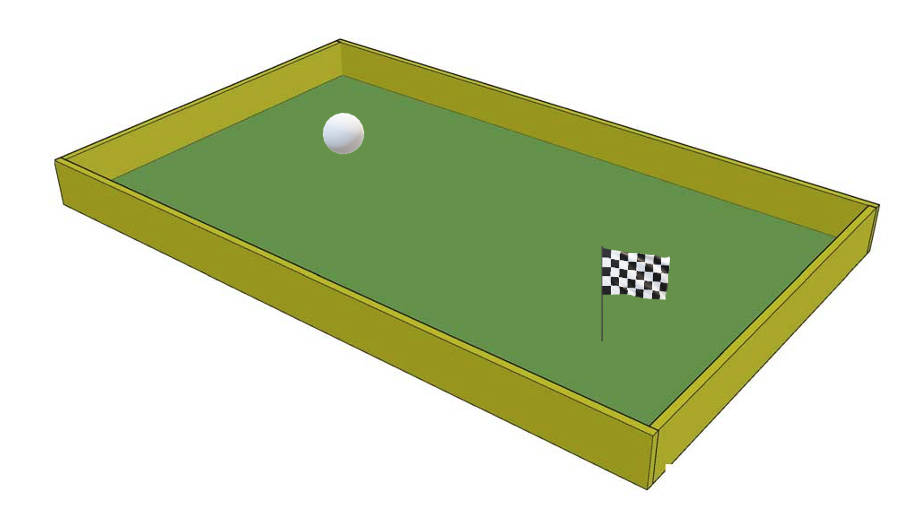

### Environment:

In the 2D Marble environment, the 2D plane is created for the marble to roll in four directions: left, right, up, and down. The goal for the game is randomly positioned in the plane for the marble to navigate the plane and locate the goal using the Q-Learning algorithm. The environment is set up to allow the marble to be placed either in a random position or a specific position for the initial navigation location. The velocity of the marble will allow the marble to move in the environment. The reward for the marble is incremented when the marble is close to the boundary of the goal. This will allow the marble to learn and take more steps closer to the goal during the learning process.

In [1]:
import collections
from copy import deepcopy as copy
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline

In [2]:
class Standardizer:
    def __init__(self, X, explore=False):
        self._mu = np.mean(X, 0)
        self._sigma = np.std(X, 0)
        if explore:
            print("mean: ", self._mu)
            print("sigma: ", self._sigma)
            print("min: ", np.min(X, 0))
            print("max: ", np.max(X, 0))

    def add_ones(self, A):
        return np.insert(A, 0, 1, axis=len(np.array(A).shape) - 1)

    def set_sigma(self, s):
        self._sigma[:] = s

    def standardize(self, X):
        return (X - self._mu) / self._sigma

    def unstandardize(self, X):
        return (X * self._sigma) + self._mu

Below is the one dimensional Marble class which initializes the marble on the 1D plane. In this class, the possible actions which can be taken include moving left, right, or no action. Each action is defined as a discrete number. It determines the distance the marble moves on the one-dimensional plane. The goal state is the destination point which the marble has to explore in the environment.

In [3]:
class Marble1D:
    """ 
    1D Marble Class
    States: x, dx
    Action: [-1,1]
    
    |            ___                     |
    |___________|///|____G_______________|
                <- ->
    """
    def __init__(self, goal=5, bound=[0, 10, -5, 5]):
        """ 
        Initializes the marble game board
        
        goal (float): x position of goal where marble must within self.goal_width 
            of this goal to complete the task.
        
        bound (list): Contains bounds for marble game.
            [x lower boundary, x upper boundary, min x negative velocity, max x positive velocity]
        """
        # Number of state features
        self.n_state = 2

        # Number of actions = 3 actions [-1, 0, 1]
        self.n_action = 3

        # Location of goal given by its x position
        self.goal = goal

        # Sets boundaries for x and dx velocity
        self.bound = bound

        # Tries to set defaults if bad input for bound is given
        if len(self.bound) != 4:
            self.bound = self.bound[:2] + [-5, 5]

        # Creates an array where the 1st row contains min values and the 2nd row
        # contains max vaules. Useful for continuous actions.
        # [[ x lower boundary, min x negative velocity, min action]
        # [x upper boundary, max x positive velocity, max action]]
        self._st_range = np.array([self.bound[:2], self.bound[2:], [-1, 1]]).T

        # Used check if marble is within a certain distance of the goal
        self.goal_width = 1

        # Initialize start state in case self.init isn't called
        # s[0] = x position
        # s[1] = dx or velocity in the x direction
        self._s = [0, 0]

    def init(self, start=None):
        """
        Initializes starting state for board                 
        If you want to set a specific starting state or a random one call this funtion!

        Args:
        start (list): start[0] should contain the starting x 
                        position of the marble and s[1] should contain the
                        starting dx velocity. 
        """
        if start is not None:
            # Set start state to passed x and dx
            self._s = start
        else:
            # Randomly select start position between x bounds
            self._s = [np.random.randint(self.bound[0], self.bound[1]), 0.]
        return self._s

    def get_random_action(self):
        """ Randomly select a discrete action INDEX for 3 actions """
        return float(np.random.randint(3) - 1)

    def get_bound_act(self, a):
        if a[0] > 1:
            return 1
        elif a[0] < -1:
            return -1
        else:
            return a[0]

    def next(self, a):
        """ 
        Given an action moves state s to next state s1
        
        Args:
        a (numeric): Action taken whose value can be
                        -1 for moving left, 0 for no movement, or 1
                        for moving right.

        Returns: Reward given marble is within goal location bounds
        """
        # Store curent state
        s = self._s

        # If object is iterable then it selects the first index.
        if isinstance(a, collections.Iterable):
            a = a[0]

        # Copies current state values into next state so they can be updated.
        s1 = copy(s)
        # Set velocity variable for increasing velocity over time
        dT = 0.1

        # Update x position
        s1[0] += dT * s[1]
        # Update dx velocity (i.e., velocity of x)
        s1[1] += dT * (2 * a - 0.2 * s[1])

        # Adjust x velocity when hitting the bounds or the sides of the case/track. 
        # Set veloctiy to 0 and set x position equal to the x bound.
        if s1[0] < self.bound[0]:
            s1[:] = [self.bound[0], 0]
        elif s1[0] > self.bound[1]:
            s1[:] = [self.bound[1], 0]

        # Clips velocity in postive and negative x direction
        s1[1] = np.clip(s1[1], self._st_range[0, 1], self._st_range[1, 1])

        # Set next state equal to current state
        self._s = s1

        return self.get_reward(s=s, a=a, s1=s1)

    def get_cur_state(self):
        """Returns the current state features"""
        return self._s

    def get_reward(self, s, s1, a):
        """ 
        Returns current reward
        If marble's next state s1 is within a certain distance
        of the goal then a positive reward of 1 is given,
        else 0 reward is given. The distance to the goal in order 
        to recieve a positive reward is determined by self.goal_width.
        """
        return 1 if abs(s1[0] - self.goal) < self.goal_width else 0

    def get_state_range(self):
        """ 
        Returns state min and max values
        This is basically the same as self.boundaries but given as an NumPy array.
        """
        return self._st_range

    def get_actions(self):
        """ 
        Return all possible actions
        Notes:
            move left = -1
            don't move = 0
            move right = 1
        """
        return np.array([-1., 0., 1.])

    def get_action_index(self, action):
        """ Returns index of a selected action """
        return np.where(np.array([-1, 0, 1]) == action)[0][0]

    def draw_trajectory(self, smplX):
        if smplX.shape[1] == 1: return
        plt.plot(smplX[:, 0], smplX[:, 1])
        plt.axis([self.bound[0], self.bound[1], -5, 5])
        plt.plot(smplX[0, 0], smplX[0, 1], 'go')
        plt.plot(self.goal, 0, 'ro')
        # draw a goal region
        plt.fill_between(
            [self.goal - self.goal_width, self.goal + self.goal_width],
            [-5, -5], [5, 5],
            color="red",
            alpha=0.3)
        plt.xlabel("s")
        plt.ylabel("s dot")

Below is the implementation of the 2D Marble Class where the 1D Marble class is extended to modify certain functions to accommodate the changes required for creating the 2D environment. Below is the detailed summary of the changes made for the 2D Marble class:

* <b>______init__:</b> Initialized and modified the required variables like the state, action, goal, boundaries, and start range.
* <b>init:</b> Initialized and modified the starting state of the 2D marble.
* <b>get_random_action:</b> Modified the number of actions to generate the random action.
* <b>next:</b> Modified the function to move to the next state based on the action provided. 
* <b>get_reward:</b> Modified the reward function to account for both x and y position.
* <b>get_actions:</b> Modified the actions to account for the up and down move.
* <b>get_num_actions:</b> Created a new function to get the count of the actions.

In [4]:
class Marble2D(Marble1D):
    """ 
    2D Marble Class
    States: x, dx, y, dy
    Action: [0, -1], [0, 1], [-1, 0], [1, 0]
    """

    def __init__(self, goal=[5, 5], bound=[0, 10, -5, 5, 0, 10, -5, 5]):
        """ 
        Initializes the marble game board

        goal (float): x position of goal where marble must within self.goal_width 
            of this goal to complete the task.

        bound (list): Contains bounds for marble game.
            [x lower boundary, x upper boundary, min x negative velocity, max x positive velocity]
        """
        # Number of state features - [x, dx, y, dy]
        self.n_state = 4

        # Number of actions. 5 actions [0, -1], [0, 1], [-1, 0], [1, 0]
        self.n_action = 5

        self.actions = np.array([[0, -1], [0, 1], [-1, 0], [1, 0]])

        # Location of goal given by its x position
        self.goal = np.array(goal)

        # Sets boundaries for x and dx velocity
        self.bound = bound

        # Creates an array where the 1st row contains min values and the 2nd row contains max vaules.
        #  [ x lower bound, min x neg v, min x action, y lower bound, min y negative v, min y action ]
        #  [ x upper bound, max x pos v, max x action, y upper bound, max y positive v, max y action ]

        self._st_range = np.array([
            self.bound[:2], self.bound[2:4], self.bound[4:6], self.bound[6:8], [-1, 1], [-1, 1]
        ]).T

        # Used check if marble is within a certain distance of the goal
        self.goal_width = [1, 1]

        # Initialize start state in case self.init isn't called
        # s[0] = x position
        # s[1] = dx or velocity in the x direction
        # s[2] = y position
        # s[3] = dy or velocity in the x direction
        self._s = [0, 0, 0, 0]

    def init(self, start=None):
        """ 
        Initializes starting state for board      
        Set a specific starting state or a random one call this funtion!
        Args:
        start (list): start[0] should contain the starting x 
                        position of the marble and s[1] should contain the
                        starting dx velocity. 
        """
        if start is not None:
            # Set start state to passed x, dx, y, dy
            self._s = start
        else:
            # Randomly select start position between x bounds
            self._s = [np.random.randint(self.bound[0], self.bound[1]), 0.,
                       np.random.randint(self.bound[4], self.bound[5]), 0.]
        return self._s

    def get_random_action(self):
        """ Randomly select a discrete action INDEX """
        return float(np.random.randint(self.n_action) - 1)

    def next(self, a):
        """ 
        Given an action moves state s to next state s1
        Args:
        a (numeric): Action taken whose value can be any one from the actions list
        Returns: Reward given marble is within goal location bounds
        """
        # Store curent state
        s = self._s

        # Copies current state values into next state
        # so they can be updated.
        s1 = copy(s)
        # Set velocity variable for increasing velocity over time
        dT = 0.1

        # Update x position
        s1[0] += dT * s[1]
        # Update dx velocity (i.e., velocity of x)
        s1[1] += dT * (2 * a[0] - 0.2 * s[1])

        # Update y position
        s1[2] += dT * s[3]
        # Update dy velocity (i.e., velocity of y)
        s1[3] += dT * (2 * a[1] - 0.2 * s[3])

        # Adjust x velocity when hitting the bounds
        # or the sides of the case/track. Set veloctiy
        # to 0 and set x position equal to the x bound.

        # bound=[0, 10, -5, 5, 0, 10, -5, 5]
        # s1 = [x, dx, y, dx]

        if s1[0] < self.bound[0]:
            s1[0:2] = [self.bound[0], 0]
        elif s1[0] > self.bound[1]:
            s1[0:2] = [self.bound[1], 0]

        if s1[2] < self.bound[4]:
            s1[2:4] = [self.bound[4], 0]
        elif s1[2] > self.bound[5]:
            s1[2:4] = [self.bound[5], 0]

        # Clips velocity in postive and negative x direction
        s1[1] = np.clip(s1[1], self._st_range[0, 1], self._st_range[1, 1])
        s1[3] = np.clip(s1[3], self._st_range[0, 3], self._st_range[1, 3])

        # Set next state equal to current state
        self._s = s1

        return self.get_reward(s=s, a=a, s1=s1)

    def get_cur_state(self):
        """ Returns the current state features """
        return self._s

    def get_reward(self, s, s1, a):
        """ 
        Returns current reward

        If marble's next state s1 is within a certain distance
        of the goal then a positive reward of 1 is given,
        else 0 reward is given. The distance to the goal in order 
        to recieve a positive reward is determined by self.goal_width.
        """
        reward = 0
        if abs(s1[0] - self.goal[0]) < self.goal_width[0]:
            reward = 1
        if abs(s1[2] - self.goal[1]) < self.goal_width[1]:
            reward = 1   
        return reward

    def get_state_range(self):
        """ Returns state min and max values"""
        return self._st_range

    def get_actions(self):
        """ Return all possible actions """
        return self.actions

    def get_num_actions(self):
        """ Return the count of the actions """
        return self.n_action

## Mountain Car

<img src="https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/MountainCarContinuous-v0/poster.jpg" data-video-type="video/mp4" data-video-source="https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/MountainCarContinuous-v0/original.mp4">

### Environment:

A car is on a one-dimensional track, positioned between two mountains. The main goal in this problem is to drive the car up the mountain on the right. The main challenge in this problem is that the car's engine is not strong enough to scale the mountain in a single pass so the car has to be driven back and forth to build up momentum. The car can accumulate greater if it spends less energy to reach the goal.

In this problem, the action of the car is a continuous value. When the car reaches the top to the top of the hill on the right or goes beyond it, then the episode terminates. The car can climb to the left side of the hill to gain potential energy and accelerate towards the goal. When the car reaches the top of the left mountain, the position (when it reaches -1) then the car hits the wall and cannot go further. When it hits the limit, the car is not penalized.

In [5]:
import gym
env = gym.make('MountainCarContinuous-v0')

Below are some of the observations from the Mountain Car Continuous Environment:

In [6]:
print(f"Environment Shape: {env.observation_space.shape}")
print(f"Action Space: {env.action_space}")
print(f"Environment Lowest: {env.observation_space.low}")
print(f"Environment Highest: {env.observation_space.high}")
print(f"Action Space Range (-1 -> left, +1 -> right): {env.action_space.low[0], env.action_space.high[0]}")
print(f"Reward Range: {env.reward_range}")
print(f"Max Speed: {env.max_speed}")

Environment Shape: (2,)
Action Space: Box(1,)
Environment Lowest: [-1.2  -0.07]
Environment Highest: [0.6  0.07]
Action Space Range (-1 -> left, +1 -> right): (-1.0, 1.0)
Reward Range: (-inf, inf)
Max Speed: 0.07


### Functions:

- **gym.make(env)** - It will initialize the given environment from the list of environments provided in OpenAi Gym.
- **env.reset()**  - It will reset the environment and returns an initial observation.
- **env.render()** - It will open a window which will render the game by taking the specified action.
- **env.step()**   - It will take an action for each step.

### Observation
The environment shape is Box(2) which contains the car's position and velocity.
- Car Position: (-1.2, 0.6)
- Car Velocity: (-0.07, 0.07)

### Action
The action for the car is continuous so it is type Box(1). The car can be pushed left with a negative value and right with a positive value. 

### Reward
The car can receive the reward of 100 minus the squared sum of actions from start to goal when it reaches the target goal on the top of the right mountain. The challenge in the reward function is that if the agent cannot figure out the way to reach the goal soon, then it will find out that not moving is a better move and will not take action to find the target.

# III. Methods

- Decide your TD learning approach: SARSA or Q-learning? 
- Describe your neural network function approximator (how many hidden unites? why?).
- Describe your approach and the reason why you select it.
- Explain your codes.

## 2D Marble Control

### Method: Temporal Difference Learning with Q-Learning
In this problem, the Q-Learning algorithm is used for the RL agent because, in the marble environment, the function approximation can be used to produce a good estimation over the next unexperienced state space based on the experience which is built from the limited set of the state space. Since Q-learning is an off-policy algorithm that works best where the state space and action space are discrete, it would best work on this problem as the state and action space is discrete.

### Q-learning Algorithm:
In this algorithm, the main goal is to allow the Q-function to predict the best action for the state to maximize the total reward. The Q-function is estimated by updating the Q-function through the number of iteration. The agent tries to exploit the known paths which are already explored by the agent (exploiting) and also tries to learn from the actions outside the policy (exploring) by using the epsilon which balances which action to perform. 

**Below is the pseudocode for the algorithm:**
![](http://incompleteideas.net/book/ebook/pseudotmp9.png)

### Marble RLAgent

Below is the implementation of the RL Agent for the 2D Marble class where the Q Learning algorithm is implemented with the neural network function approximator. In the init function, the environment variables and neural network variables are initialized. The init function uses the environment, number of episodes, number of steps, number of actions, gamma, and epsilon for the agent. The agent has some helper functions defined like add_ones which adds a constant column of 1's to the input NumPy array. The as_array function converts the input array to a NumPy array and performs validation for the bad input. 

The forward and backward function is the neural network function that helps to update the neural network weights. The forward function performs the forward pass on the training data. The backward function performs the backpropagation step and updates the weight. The explosion greedy function determines the action for the agent based on the epsilon and the step. It helps to control the exploration and exploitation level (exploration-exploitation dilemma) by selecting the appropriate action. 

The train function performs the Q Learning algorithm to train the agent by looping through the number of episodes. For each episode, the environment is reset and the current state and action are calculated. Then for each step, the next reward and next state would be calculated and the reward for that step is calculated. The weight for the neural networks is updated and the error weight is captured. The next state and action are then set as the current state and action for the next step. The train function also has the option to display the plots for the training result. 

The test function tests the agent which is trained in the training function. It also displays the plot for the state trajectories for the epsilon. The find_best_parameters function is used to find the best value for the number of hidden layers required to train the neural network.

**Neural Network Approximator:** 
* The train function takes the number of hidden units to be used for training the neural network model. Based on the input specified, the model will be trained.
* The find_best_params function is created to test different values for the hidden units and determine the best working parameter for training the RL agent.

In [7]:
class MarbleRLAgent:
    """
        Reinforcement Learning Marble Agent Model for training/testing
        with Q-Learning algorithm
        
    """
        
    def __init__(self, env, ep=10, s=100, g=0.9, e=1.0, fe=0.01):
        # Environment Variables
        self.env = env
        self.episodes = ep
        self.steps = s
        self.actions = self.env.get_actions()
        self.gamma = g
        self.epsilon = e
        self.final_epsilon = fe
        self.epsilon_decay = np.exp(np.log(self.final_epsilon) / self.episodes)

        # Neural Network Variables
        self.stdX = Standardizer(self.env.get_state_range())
        self._V = []
        self._W = []
        self._rh = []
        self._ro = []

    def add_ones(self, A):
        return np.insert(A, 0, 1, axis=len(np.array(A).shape) - 1)

    def as_array(self, A):
        A = np.array(A)
        if len(A.shape) == 1:
            return A.reshape((1, -1))
        return A

    def forward(self, X):
        X = self.stdX.standardize(X)
        X1 = self.add_ones(X)
        Z = np.tanh(X1 @ self._V)
        Z1 = self.add_ones(Z)
        Y = Z1 @ self._W
        return Y, Z

    def backward(self, error, Z, X):
        X = self.as_array(X)
        Z = self.as_array(Z)
        E = self.as_array(error)

        Z1 = self.add_ones(Z)
        X1 = self.add_ones(X)

        dV = self._rh * X1.T @ ((E @ self._W[1:, :].T) * (1 - Z**2))
        dW = self._ro * Z1.T @ E
        return dV, dW

    def epsilon_greedy(self, e, s):
        if np.random.rand() < e:
            return self.actions[np.random.randint(self.env.get_num_actions()) - 1]
        else:
            Q, _ = self.forward(np.hstack((np.tile(s, (len(self.actions), 1)), self.actions)))
            max_as = np.where(Q == np.max(Q))[0] - 1
            return self.actions[np.random.choice(max_as)]

    def train(self, n_hidden=150, display_plots=False):
        n_samples = 1
        n_outputs = 1
        n_inputs = 6
        rhoh = rhoo = 0.01

        self._rh = rhoh / (n_samples * n_outputs)
        self._ro = rhoo / (n_samples * n_outputs)

        self._V = 0.1 * 2 * \
            (np.random.uniform(size=(n_inputs + 1, n_hidden)) - 0.5)
        self._W = 0.1 * 2 * \
            (np.random.uniform(size=(1 + n_hidden, n_outputs)) - 0.5)

        rtrace = []
        etrace = [self.epsilon]
        if display_plots:
            fig = plt.figure(figsize=(8, 8))

        for episode in range(self.episodes):
            # Initialize the game
            self.env.init()
            # Current state
            state = self.env.get_cur_state()
            # Select the action
            action = self.epsilon_greedy(self.epsilon, state)

            rewards = []
            trace = np.array(state)

            for step in range(self.steps):
                reward_next = self.env.next(action)
                state_next = self.env.get_cur_state()
                action_next = self.epsilon_greedy(self.epsilon, state_next)
                rewards.append(reward_next)
                trace = np.vstack((trace, state_next))

                # Update neural networks
                Q1, _ = self.forward(np.hstack((state_next, action_next)))
                Q, Z = self.forward(np.hstack((state, action)))
                error = reward_next + self.gamma * Q1 - Q
                dV, dW = self.backward(error, Z, np.hstack((state, action)))
                self._V += dV
                self._W += dW

                state = state_next
                action = action_next

            self.epsilon *= self.epsilon_decay
            etrace.append(self.epsilon)

            # print(f"Episode {episode} Reward: {np.sum(rewards)}")
            rtrace.append(np.sum(rewards))

            if display_plots:
                last_plot = (episode == self.episodes - 1)
                if episode % 10 == 0 or last_plot:
                    plt.clf()
                    fig.add_subplot(221)
                    plt.plot(rtrace, "-")
                    plt.ylabel("Reward Sum:")
          
                    fig.add_subplot(222)
                    plt.plot(trace[:, 0], trace[:, 2], "k-")
                    plt.fill_between([4,6], [4,4], [6, 6], color='red', alpha=0.3)
                    plt.title("Trace of Last Episode")
                    plt.xlim([0, 10])
                    plt.ylim([0, 10])
                    # plt.suptitle(f"Episode {str(episode+1)}")
                    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                    plt.draw()

        average_reward = sum(rtrace) / len(rtrace)
        # print(f"Average Reward: {average_reward}")

        if display_plots:
            ipd.clear_output(wait=True)

        return average_reward

    def test(self, n_trials, n_steps_per_trial):
        xs = np.linspace(0, 10, n_trials)
        ys = np.linspace(0, 10, n_trials)
        for i in xs:
            state = self.env.init([i, 0, i, 0])  # 0 velocity for x,y
            xtrace = np.zeros((n_steps_per_trial, 2))
            ytrace = np.zeros((n_steps_per_trial, 2))
            a = self.env.get_actions()
            for step in range(n_steps_per_trial):
                action = self.epsilon_greedy(self.epsilon, state)
                self.env.next(action)
                state = self.env.get_cur_state()
                xtrace[step, :] = [state[0], state[1]]
                ytrace[step, :] = [state[2], state[3]]
            plt.plot(xtrace[:, 0], xtrace[:, 1], ytrace[:, 0], ytrace[:, 1])
            plt.xlim(0, 10, 0, 10)
            plt.ylim(0, 10, 0, 10)
            plt.plot([5, 5, 5, 5], [-5, 5, -5, 5], '--', alpha=0.5, lw=5)
            plt.ylabel('$\dot{y}$')
            plt.xlabel('$x$')
            plt.title(f'State Trajectories for $\epsilon={self.epsilon}$')
            
    def find_best_params(self, n_hidden=[100,120,150,170,200], epsilons=[0.5, 0.8, 0.9, 1.0], show_plots=False):
        nn_rewards = []
        epsilon_rewards = []
        
        for p in n_hidden:
            marble_env = Marble2D()
            marble_agent = MarbleRLAgent(env=marble_env, ep=200, s=50, g=0.9, e=1.0, fe=0.1)
            # print(f"# Hidden Layers: {str(p)}")
            r = marble_agent.train(n_hidden=p, display_plots=show_plots)
            nn_rewards.append(r)
        fig = plt.figure(figsize=(8, 4))
        plt.plot(nn_rewards, "-")
        xi = list(range(len(n_hidden)))
        plt.xticks(xi, n_hidden)
        plt.ylabel("Average Reward")
        plt.xlabel("# Hidden Layers")
        
        best_hidden_layer = n_hidden[nn_rewards.index(max(nn_rewards))]
        
        for e in epsilons:
            marble_env = Marble2D()
            marble_agent = MarbleRLAgent(env=marble_env, ep=200, s=50, g=0.9, e=e, fe=0.1)
            # print(f"Epsilon: {str(e)}")
            r = marble_agent.train(n_hidden=best_hidden_layer, display_plots=show_plots)
            epsilon_rewards.append(r)
        fig = plt.figure(figsize=(8, 4))
        plt.plot(epsilon_rewards, "-")
        xi = list(range(len(epsilons)))
        plt.xticks(xi, epsilons)
        plt.ylabel("Average Reward")
        plt.xlabel("Epsilon Value")

        best_epsilon = epsilons[epsilon_rewards.index(max(epsilon_rewards))]

        return best_hidden_layer, best_epsilon

## Mountain Car

### Method: Temporal Difference Learning with Q-Learning
In this problem, the Q-Learning algorithm is used for the Mountain Car RL agent because, in this environment, the state space is a 2-dimensional box where a position or negative action can be taken to move the car into the left or right direction.
The Q-learning algorithm can be applied to finding the best estimation for the next state space based on the experience gathered from previous states.

### Q-learning Algorithm:
In this algorithm, the main goal is to allow the Q-function to predict the best action for the state to maximize the total reward. The Q-function is estimated by updating the Q-function through the number of iteration. The agent tries to exploit the known paths which are already explored by the agent (exploiting) and also tries to learn from the actions outside the policy (exploring) by using the epsilon which balances which action to perform.

### Mountain Car RL-Agent

Below is the implementation of the RL Agent for the Mountain Car class where the Q Learning algorithm is implemented with the neural network function approximator. In the init function, the environment variables for the MountainCarContinous environment is used. The environment variables for the game are derived from the openAi gym and initialized to set up the environment. The neural network variables are also declared to be used in training functions. 

The agent has some helper functions defined like add_ones which adds a constant column of 1's to the input NumPy array. The as_array function converts the input array to a NumPy array and performs validation for the bad input. 

The forward and backward function is the neural network functions which help to update the neural network weights. The forward function performs the forward pass on the training data. The backward function performs the backpropagation step and updates the weight. The epsilon greedy function determines the best action for the agent based on the epsilon.

The train function performs the Q Learning algorithm to train the agent by looping through the number of episodes. For each episode, the environment is reset and the current state and action are calculated. Then for each step, the next reward and next state would be calculated and the reward for that step is calculated. The weight for the neural networks is updated and the error weight is captured. The next state and action are then set as the current state and action for the next step. The train function also has the option to display the plots for the training result.

**Neural Network Approximator:** 
* The train function takes several hidden units to be used for the training of the neural network model. Based on the input specified, the model will be trained.
* The find_best_params function is created to test different values for the hidden units and determine the best working parameter for training the RL agent.

In [8]:
import gym

In [9]:
class MountainCarRLAgent:
    """
        Reinforcement Learning Mountain Car Agent Model for training/testing
        with Q-Learning algorithm
        
    """
    
    def __init__(self, env=gym.make('MountainCarContinuous-v0'), ep=10, s=100, g=0.9, e=1.0, fe=0.1):
        # Environment Variables
        self.env = env
        self.episodes = ep
        self.steps = s
        self.gamma = g
        self.epsilon = e
        self.final_epsilon = fe
        self.epsilon_decay = np.exp(np.log(self.final_epsilon) / self.episodes)
        
        # Action
        self.n_action = self.env.action_space.shape[0]
        self.lower_bound = self.env.observation_space.low
        self.upper_bound = self.env.observation_space.high
        self.actions_range = np.array([env.action_space.low[0], env.action_space.high[0]])
        self.st_range = np.array([self.lower_bound, env.observation_space.low[1],
                                  self.upper_bound, env.observation_space.low[0]]).T
        self.stdX = Standardizer(np.array(self.st_range))

        # Neural Network Variables
        self._V = []
        self._W = []
        self._rh = []
        self._ro = []

    def add_ones(self, A):
        return np.insert(A, 0, 1, axis=len(np.array(A).shape) - 1)

    def as_array(self, A):
        A = np.array(A)
        if len(A.shape) == 1:
            return A.reshape((1, -1))
        return A
    
    def forward(self, X):
        X = self.stdX.standardize(np.array([X]))
        X1 = self.add_ones(X)
        Z = np.tanh(X1 @ self._V)
        Z1 = self.add_ones(Z)
        Y = Z1 @ self._W
        return Y, Z

    def backward(self, error, Z, X):
        X = self.as_array(X)
        Z = self.as_array(Z)
        E = self.as_array(error)

        Z1 = self.add_ones(Z)
        X1 = self.add_ones(X)

        dV = self._rh * X1.T @ ((E @ self._W[1:, :].T) * (1 - Z ** 2))
        dW = self._ro * Z1.T @ E
        return dV, dW

    def epsilon_greedy(self, e, s):
        if np.random.rand() < e:
            return np.random.randint(2) - 1
        else:
            Q, _ = self.forward(np.hstack((np.tile(s, (len(self.actions), 1)), self.actions)))
            max_as = np.where(Q == np.max(Q))[0] - 1
            return np.random.choice(max_as)

    def train(self, n_hidden=150, display_plots=False):
        n_samples = 1
        n_outputs = 1
        n_inputs = 2
        rhoh = rhoo = 0.01
        
        self._rh = rhoh / (n_samples * n_outputs)
        self._ro = rhoo / (n_samples * n_outputs)

        self._V = 0.1 * 2 * \
            (np.random.uniform(size=(n_inputs + 1, n_hidden)) - 0.5)
        self._W = 0.1 * 2 * \
            (np.random.uniform(size=(1 + n_hidden, n_outputs)) - 0.5)
        
        rtrace = []
        etrace = [self.epsilon]
        if display_plots:
            fig = plt.figure(figsize=(8, 8))

        for episode in range(self.episodes):
            # Current state
            state = self.env.reset()
            # Select the action
            action = self.epsilon_greedy(self.epsilon, state)
            
            rewards = []
            trace = np.array(state)
            
            for step in range(self.steps):
                reward_next = self.env.step(np.array([action]))
                state_next = self.env.reset()
                action_next = self.epsilon_greedy(self.epsilon, state_next)
                rewards.append(reward_next)
                trace = np.vstack((trace, state_next))
                
                Q1, _ = self.forward(np.hstack((state_next, action_next)))
                Q, Z = self.forward(np.hstack((state, np.array(action))))
                                
                error = np.array([reward_next])[0] + self.gamma * Q1 - Q
                dV, dW = self.backward(error, Z, np.hstack((state, action)))
                self._V += dV
                self._W += dW
                
                state = state_next
                action = action_next

            self.epsilon *= self.epsilon_decay
            etrace.append(self.epsilon)
            
            # print(f"Episode {episode} Reward: {np.sum(rewards)}")
            rtrace.append(np.sum(rewards))
            
            if display_plots:
                last_plot = (episode == self.episodes - 1)
                if episode % 10 == 0 or last_plot:
                    plt.clf()
                    fig.add_subplot(221)
                    plt.plot(rtrace, "-")
                    plt.ylabel("Reward Sum:")

                    fig.add_subplot(222)
                    average_reward = sum(rtrace) / len(rtrace)
                    plt.axhline(y=average_reward, color='lightgreen')
                    plt.title("Average Reward")
                    
        if display_plots:
            ipd.clear_output(wait=True)
            
        average_reward = sum(rtrace) / len(rtrace)
        # print(f"Average Reward: {average_reward}")
        return average_reward
    
    def find_best_params(self, n_hidden=[100,120,150,170,200], show_plots=False):
        avg_rewards = []
        for p in n_hidden:
            env = gym.make('MountainCarContinuous-v0')
            mountain_car_agent = MountainCarRLAgent(env=env, ep=10, s=100, g=0.9, e=1.0, fe=0.1)
            r = mountain_car_agent.train(n_hidden=p, display_plots=show_plots)
            avg_rewards.append(r)
        plt.clf()
        fig = plt.figure(figsize=(4, 4))
        plt.plot(avg_rewards, "-")
        plt.ylabel("Average Reward")
        plt.xlabel("# Hidden Layers")
        plt.xticks(n_hidden)
        plt.plot()
        
    def run(self, display_plots=False, render_env=False):
        episode_return = 0.0
        rc_trace = []
        for episode in range(self.episodes):
            state = env.reset()
            while True:
                if render_env:
                    env.render()
                # Choose the action
                action = env.action_space.sample()
                # Run the action
                next_state, reward, done, info = env.step(action)
                # Run the update
                episode_return += reward
                if done:
                    if render_env:
                        print(f"Episode {episode}: {episode_return}")
                    rc_trace.append(episode_return)
                    episode_return = 0.0
                    break
                state = next_state
        env.close()
        if display_plots:
            plt.plot(rc_trace)
            plt.ylabel("Reward")
            plt.xlabel("# Iterations")
            plt.show()

# IV - Results

- Describe the choice of your hyper-parameters for $\gamma$, $\epsilon$, the learning rates $\rho$'s, and the number of hiddend units (or other NN hyper-parameters). 
  - Run experiments to find good hyper-parameters
  - Show the experimental outputs to show the process of your selection
- Visualize the results and explain outputs 
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.

## 2D Marble Control

Below are the test parameters for the number of hidden network layers and epsilon values used for finding the good hyper-parameters for neural network.

In [10]:
hidden_nn_params = [100, 120, 150, 170, 200, 220, 240, 260, 300]
epsilon_params = [0.5, 0.8, 0.9, 1.0]

### Applying the Experiments
Below is the experimental code to create the Marble environment and run the find_best_params to retrieve the best working parameters for training and testing the RL model.

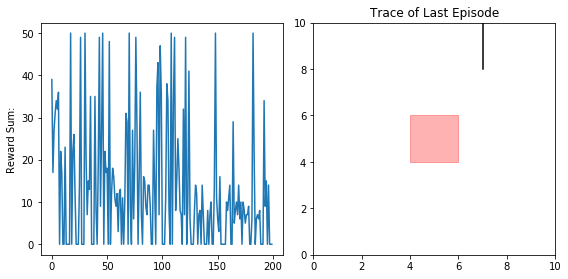

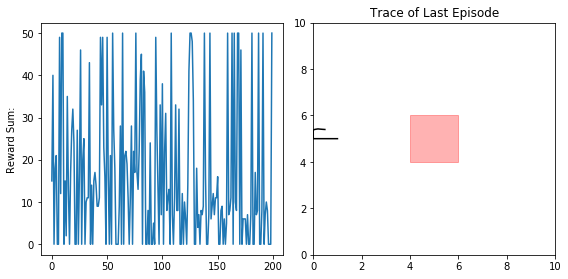

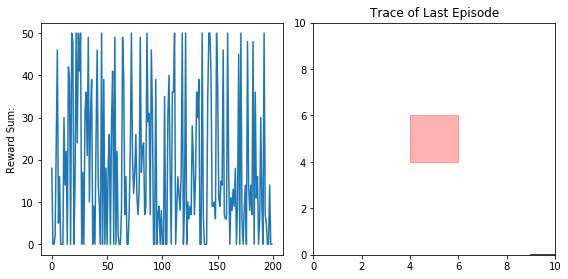

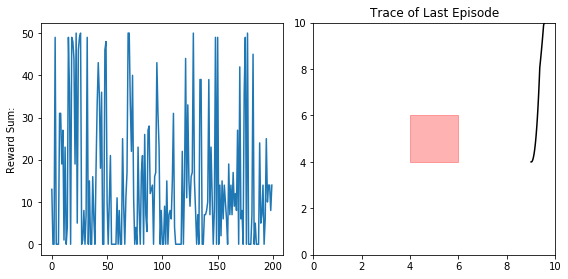

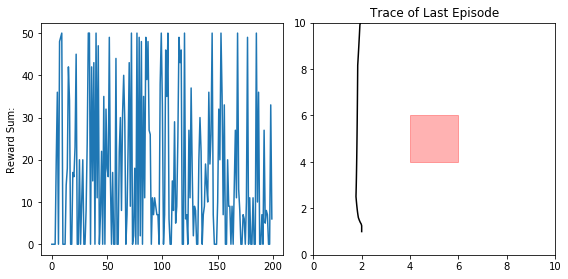

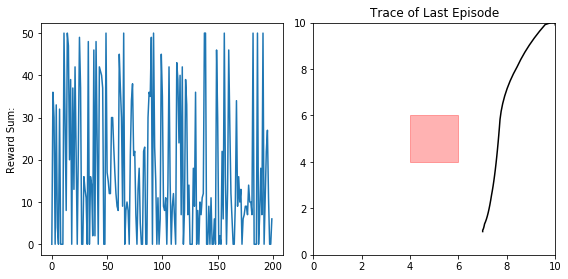

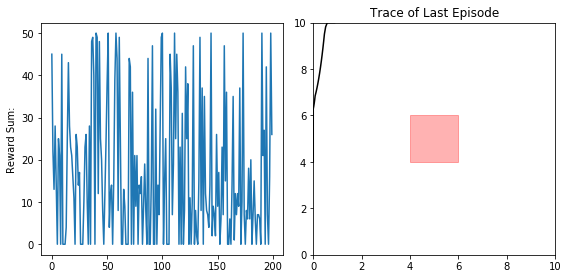

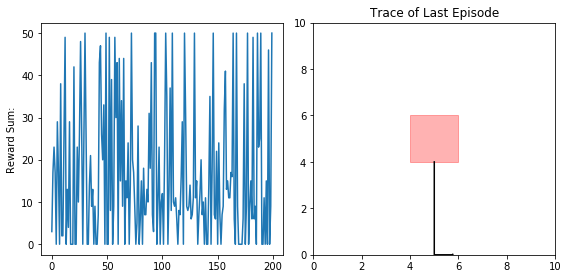

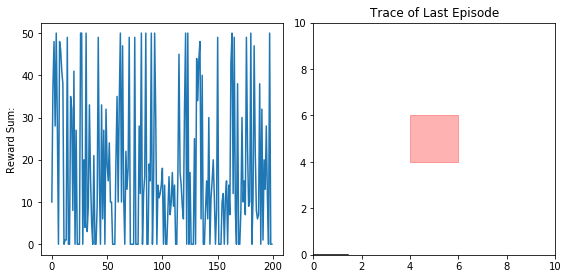

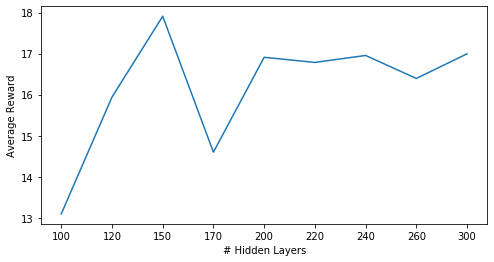

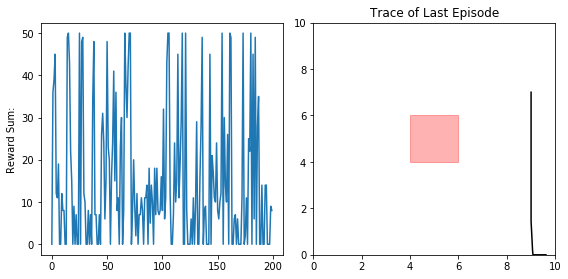

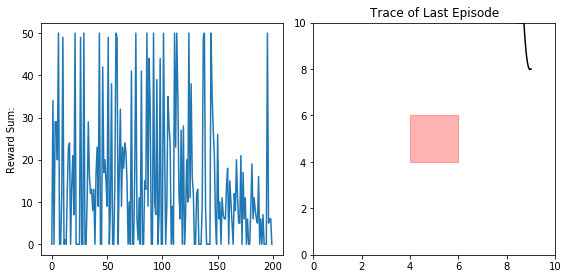

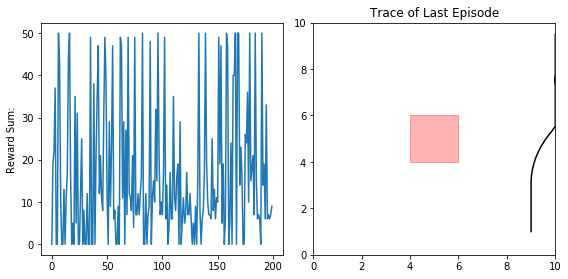

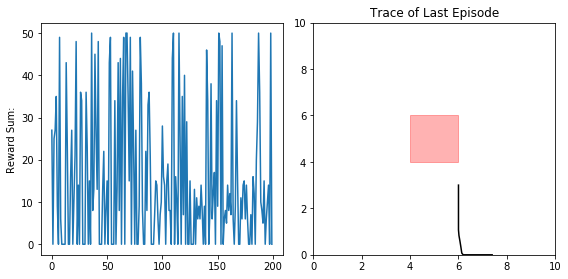

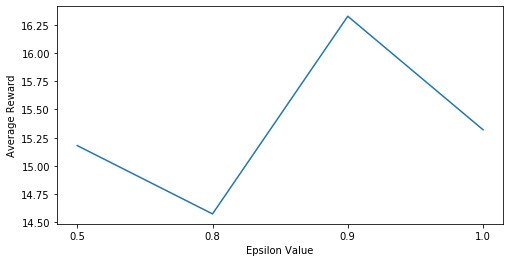

In [11]:
marble_env = Marble2D()
marble_agent = MarbleRLAgent(env=marble_env, ep=1000, s=100, g=0.9, e=0.1, fe=0.1)
best_hidden_nn, best_epsilon = marble_agent.find_best_params(n_hidden=hidden_nn_params, 
                                                             epsilons=epsilon_params, 
                                                             show_plots=True)

In the above experiment, several different epsilon values and hidden layers were tested. Based on the results. it can be seen that the best parameter for the neural network hidden layers is 150. The average reward for the RL agent declined for the 170 hidden layers and then it gradually increased and stayed stable for the other values. For the epsilon values experiment, the average reward for the model increased gradually till 0.9 and then it started fluctuating and decreased steadily. The epsilon value of 0.9 had the highest average reward.

### Training the Model:

24.65

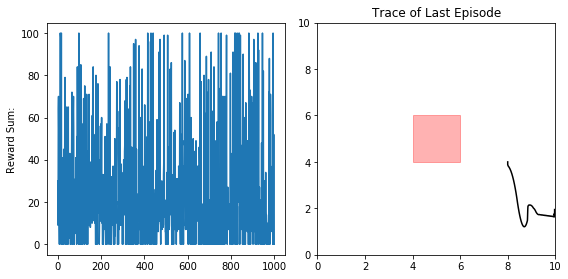

In [12]:
marble_env = Marble2D()
marble_agent = MarbleRLAgent(env=marble_env, ep=1000, s=100, g=0.9, e=best_epsilon, fe=0.1)
marble_agent.train(n_hidden=best_hidden_nn, display_plots=True)

From the training results, it can be seen that the RL agent is learning from it's previous steps which were taken by the agent. It seems like it is starting with more random actions in the beginning of the iterations and then it is also taking actions which it learned from the previous iterations.

### Testing the model:

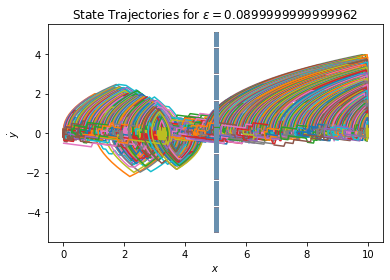

In [13]:
marble_agent.test(500, 100)

In the above visualization of the test model, the trajectories for the different episodes can be seen. Based on the plot, it can be seen how the agent is taking different paths in each episode to gain the maximum reward and reach to the goal. After some of the iterations, it took actions which it learned from the previous actions to gain maximum reward.

### Mountain Car Problem

In [14]:
import gym
env = gym.make('MountainCarContinuous-v0')

### Running the Mountain Car Continuous environment:

In [15]:
env = gym.make('MountainCarContinuous-v0')
mountain_car_agent = MountainCarRLAgent(env=env, ep=500, s=100, g=0.9, e=1.0, fe=0.1)

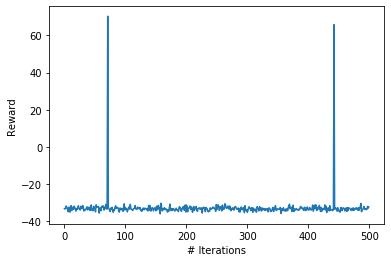

In [16]:
mountain_car_agent.run(display_plots=True, render_env=False)

From the above visualization, it can be seen that the agent was able to hit the target two times during the iterations where it was able to gain maximum reward.

# V. Conclusion

In this assignment, I have learned and implemented the Q-Learning algorithm to solve two different 
Reinforcement learning problems. It also helped me to explore and learn how to use the open-source library OpenAi gym for training the RL environments. The implementation of the RL agent also helped me to understand how neural networks can be used in reinforcement learning to train the agent.

The implementation of the 2D marble environment was a bit challenging at first but after understanding the code from the 1D marble Class, I was quickly able to extend the class and make the necessary changes that were required for converting the marble environment to the 2D plane. The implementation of the RL agent for the marble class was very challenging because I spent a lot of time debugging the code to fix the errors during the implementation. The training and testing for the RL agent were also very time-consuming.

The implementation of the RL agent for the Mountain car problem was challenging as well as time-consuming. It took some time for me to understand the mountain car environment and the functions which were available in the gym library. The implementation of the RL agent was also challenging because, in this problem, the action was continuous rather than discrete like the marble control problem.

## References

Ashish. (2018, March 23). Understanding OpenAI Gym. Retrieved from https://medium.com/@ashish_fagna/understanding-openai-gym-25c79c06eccb


OpenAI. (n.d.). Getting Started with Gym. Retrieved from https://gym.openai.com/docs/